# __<u>Initialize Cloud-AI Engine</u>__ 
> with a developed and distinct environment: __py39-VPP (Python 3.9.16)__
>> in case of env problem, you can use --> cmd Run: __conda install -n (your env) ipykernel --update-deps --force-reinstall__

> Install/Verify Packages

In [1]:
# %pip install --user --upgrade pandas
# %pip install --user --upgrade "sqlalchemy<2.0"
# %pip install --user --upgrade mariadb
# %pip install --user --upgrade -U matplotlib
# %pip install --user --upgrade seaborn
# %pip install --user -U scikit-learn
# %pip install --user --upgrade "tensorflow-gpu<2.10"
# %pip install --user --upgrade keras-rl
# %pip install --user --upgrade gym
# %pip install --user --upgrade deap
# %pip install --user --upgrade statsmodels

> Import Libraries

In [2]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from datetime import time
from deap import base, creator, tools, algorithms
from statsmodels.tsa.arima.model import ARIMA

# __<u>Configure Simulation Setup__

> Define Input Data Directory

In [3]:
loadDirectory = '../Data/ProcessedData/'

>Define Output Data Directory

In [4]:
saveDirectory = 'v1.1'
# create saveDirectory directory if it doesn't exist
if not os.path.exists(saveDirectory):
    os.makedirs(saveDirectory)
    print(f"System has created \"{saveDirectory}\" directory.")
else:
    print(f"The directory \"{saveDirectory}\" already exists.")

The directory "v1.1" already exists.


> Define colunmns and rows of pandas output

In [5]:
# pd.set_option('display.max_columns', 50)
# pd.set_option('display.max_rows', 50000)

# __<u>PV Data Processing for Model Development and Testing</u>__

> __<u> Load Pre-processed Power Plants data for each PV power plant </u>__
>> Note from ENS: 
>>   * Power_Plant 3, C_pcode __71780001~71780003__ : Seomyeon, Gyeongju-si, Gyeongsangbuk-do

In [6]:
PV1 = pd.read_csv(f"{loadDirectory}PV_71780001.gzip", compression="gzip")
PV2 = pd.read_csv(f"{loadDirectory}PV_71780002.gzip", compression="gzip") 
PV3 = pd.read_csv(f"{loadDirectory}PV_71780004.gzip", compression="gzip")

> <b>Dropped</b> unnecessary data, <b>renamed</b> column and <b>set index</b> with timestamp

In [7]:
PV1 = PV1.drop(columns={'day_power'}).rename(columns={'inst_power':'pv1_power'}).set_index('timestamp')
PV2 = PV2.drop(columns={'day_power'}).rename(columns={'inst_power':'pv2_power'}).set_index('timestamp')
PV3 = PV3.drop(columns={'day_power'}).rename(columns={'inst_power':'pv3_power'}).set_index('timestamp')

>Combine above dataFrames to <b>raw_data</b> according to the index and <b>calculated total power</b>

In [8]:
raw_data = PV1.join(PV2).join(PV3)
raw_data = raw_data.fillna(0)
# calculate the total power output and add it as a new column
raw_data['total_power'] = raw_data.sum(axis=1)
raw_data=raw_data.reset_index()
# Convert the 'timestamp' column to a pandas datetime object
raw_data['timestamp'] = pd.to_datetime(raw_data['timestamp'])
raw_data ['timestamp'][0]

Timestamp('2020-11-10 18:20:00')

In [9]:
raw_data

,timestamp,pv1_power,pv2_power,pv3_power,total_power
0,2020-11-10 18:20:00,0.0,0.0,0.0,0.0
1,2020-11-10 18:21:00,0.0,0.0,0.0,0.0
2,2020-11-10 18:22:00,0.0,0.0,0.0,0.0
3,2020-11-10 18:23:00,0.0,0.0,0.0,0.0
4,2020-11-10 18:24:00,0.0,0.0,0.0,0.0
...,...,...,...,...,...
1265481,2023-05-10 17:34:00,10.6,11.9,13.9,36.4
1265482,2023-05-10 17:35:00,10.6,11.8,13.2,35.6
1265483,2023-05-10 17:36:00,11.1,11.1,14.5,36.7
1265484,2023-05-10 17:37:00,10.4,10.7,14.8,35.9


> __<u> Customized Functions </u>__
>> Note for ENS: 
>>   * hourly data calculation
>>   * grid demand generator

In [10]:
def calculate_hourly_data(data):
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data.set_index('timestamp', inplace=True)
    hourly_data = data.resample('H').sum()
    hourly_data=hourly_data.reset_index()
    hourly_data['timestamp'] = pd.to_datetime(hourly_data['timestamp'])
    hourly_data.fillna(0, inplace=True) # Fill null values with zero
    return hourly_data

In [11]:
class GridDemandGenerator:
    def __init__(self, max_demand):
        self.max_demand = max_demand
    
    def generate_daily_grid_demand(self, timestamp):
        t = timestamp.time()
        if time(22, 0) <= t or t < time(6, 0):
            return 0.25 # 25%
        elif time(6, 0) <= t < time(14, 0):
            return 0.5  # 50%
        elif time(14, 0) <= t < time(18, 0):
            return 0.75 # 75%
        elif time(18, 0) <= t < time(22, 0):
            return 1.0 # 100%
    
    def adjust_seasonal_grid_demand(self, row):
        timestamp = pd.to_datetime(row['timestamp'])
        month = timestamp.month
        grid_demand = self.max_demand * self.generate_daily_grid_demand(timestamp)
        if month in [1, 2, 12]:
            adjustment = random.uniform(0.20, 0.25)
        elif month in [6, 7, 8, 9]:
            adjustment = random.uniform(0.10, 0.20)
        elif month in [3, 4, 5]:
            adjustment = random.uniform(-0.05, 0.10)
        elif month in [10, 11]:
            adjustment = random.uniform(-0.05, 0.15)
        else:
            adjustment = 0
        adjusted_demand = grid_demand * (1 + adjustment)
        return round(adjusted_demand, 1)
    
    def get_grid_demand(self, df):
        df['timestamp']   = pd.to_datetime(df['timestamp'])
        df['grid_demand'] = df.apply(self.adjust_seasonal_grid_demand, axis=1)
        df.fillna(0, inplace=True)
        return df

In [12]:
hourly_data = calculate_hourly_data(raw_data)
hourly_data

,timestamp,pv1_power,pv2_power,pv3_power,total_power
0,2020-11-10 18:00:00,0.0,0.0,0.0,0.0
1,2020-11-10 19:00:00,0.0,0.0,0.0,0.0
2,2020-11-10 20:00:00,0.0,0.0,0.0,0.0
3,2020-11-10 21:00:00,0.0,0.0,0.0,0.0
4,2020-11-10 22:00:00,0.0,0.0,0.0,0.0
...,...,...,...,...,...
21859,2023-05-10 13:00:00,3248.1,3603.2,3716.5,10567.8
21860,2023-05-10 14:00:00,2695.2,3407.2,3478.6,9581.0
21861,2023-05-10 15:00:00,2101.6,2716.1,3125.3,7943.0
21862,2023-05-10 16:00:00,1229.9,1350.9,1852.1,4432.9


In [13]:
new_data = GridDemandGenerator(max_demand=200).get_grid_demand(hourly_data)
new_data

,timestamp,pv1_power,pv2_power,pv3_power,total_power,grid_demand
0,2020-11-10 18:00:00,0.0,0.0,0.0,0.0,226.1
1,2020-11-10 19:00:00,0.0,0.0,0.0,0.0,215.3
2,2020-11-10 20:00:00,0.0,0.0,0.0,0.0,210.3
3,2020-11-10 21:00:00,0.0,0.0,0.0,0.0,216.8
4,2020-11-10 22:00:00,0.0,0.0,0.0,0.0,55.5
...,...,...,...,...,...,...
21859,2023-05-10 13:00:00,3248.1,3603.2,3716.5,10567.8,99.5
21860,2023-05-10 14:00:00,2695.2,3407.2,3478.6,9581.0,146.8
21861,2023-05-10 15:00:00,2101.6,2716.1,3125.3,7943.0,144.4
21862,2023-05-10 16:00:00,1229.9,1350.9,1852.1,4432.9,158.9


>Plot each column of <b>plot_data</b> against the timestamp

In [14]:
def plot_columns_vs_x(df):
    """
    Plot each column of a pandas DataFrame against the x-axis (dt column), where the x-axis is automatically
    detected based on the dtype of the column. Columns with non-numeric dtypes are ignored.
    
    Parameters:
    df (pandas DataFrame): The DataFrame to plot.
    """
    # Find the column with the datetime data and set it as the x-axis
    for col_name in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[col_name]):
            x_values = df[col_name]
            x_label = col_name
            break
    else:
        print("No datetime column found. Unable to plot.")
        return

    # Make a copy of the DataFrame with the datetime column removed
    numeric_cols = [col_name for col_name in df.columns if pd.api.types.is_numeric_dtype(df[col_name])]
    df_numeric = df[numeric_cols]
        
    # Plot each column against the x-axis
    num_cols = len(df_numeric.columns)
    fig, axs = plt.subplots(num_cols, 1, figsize=(18, 6), sharex=True)
    fig.set_facecolor(color = 'antiquewhite')
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams['font.size'] = '9'
    for i, col_name in enumerate(df_numeric.columns):
        axs[i].plot(x_values, df_numeric[col_name], label=col_name, color = 'gray')
        if '_w' in col_name:
            axs[i].set_ylabel('Watt', color='chocolate')
        elif '_c' in col_name:
            axs[i].set_ylabel('DegC', color='chocolate')
        elif '_%' in col_name:
            axs[i].set_ylabel('g/m^3', color='chocolate')
        elif 'power' in col_name:
            axs[i].set_ylabel('kW/s', color='chocolate')
        elif 'grid_demand' in col_name:
            axs[i].set_ylabel('kW/s', color='chocolate')
        else:
            axs[i].set_ylabel('Unknown', color='chocolate')
        axs[0].set_title(f'Graphical Representation of {numeric_cols} data', color='brown')
        axs[i].legend(loc="upper right")
        axs[i].grid(True, linestyle='--', alpha=0.7, color='salmon')
    plt.xlabel('Timestamp', color='chocolate')
    plt.show()

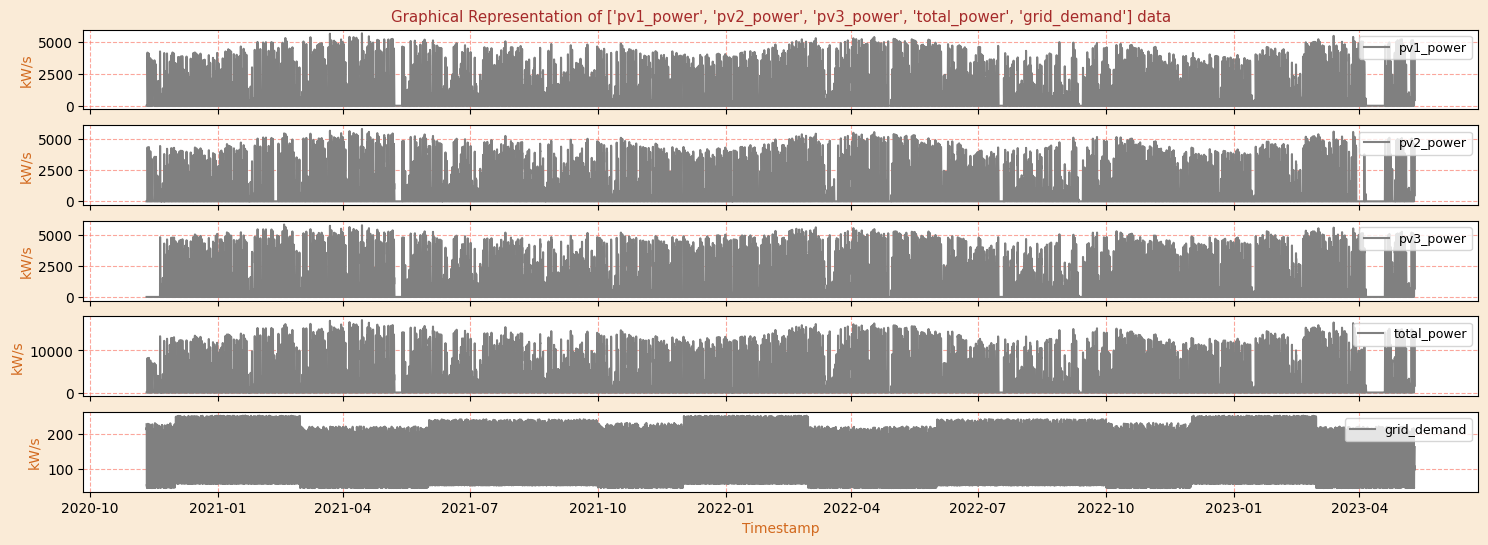

In [15]:
plot_columns_vs_x(new_data)

In [16]:
plot_data = new_data[len(new_data)-24*30:] # Last 1 month data
plot_data

,timestamp,pv1_power,pv2_power,pv3_power,total_power,grid_demand
21144,2023-04-10 18:00:00,0.0,0.0,0.0,0.0,193.3
21145,2023-04-10 19:00:00,0.0,0.0,0.0,0.0,211.6
21146,2023-04-10 20:00:00,0.0,0.0,0.0,0.0,212.1
21147,2023-04-10 21:00:00,0.0,0.0,0.0,0.0,211.7
21148,2023-04-10 22:00:00,0.0,0.0,0.0,0.0,49.6
...,...,...,...,...,...,...
21859,2023-05-10 13:00:00,3248.1,3603.2,3716.5,10567.8,99.5
21860,2023-05-10 14:00:00,2695.2,3407.2,3478.6,9581.0,146.8
21861,2023-05-10 15:00:00,2101.6,2716.1,3125.3,7943.0,144.4
21862,2023-05-10 16:00:00,1229.9,1350.9,1852.1,4432.9,158.9


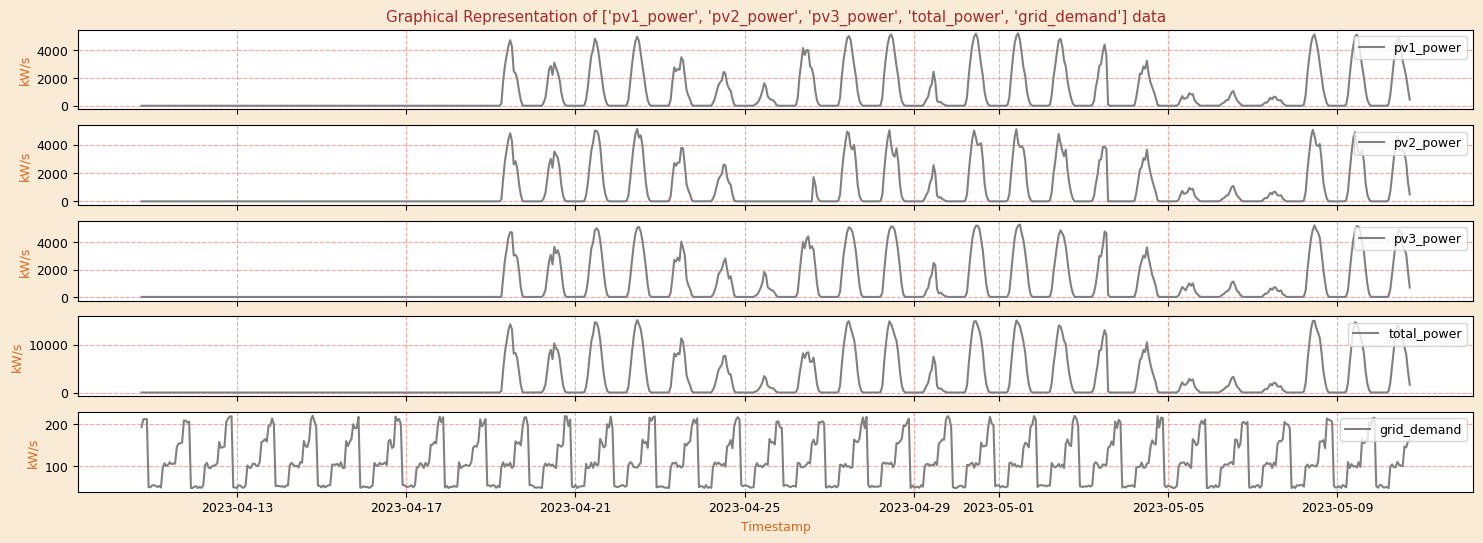

In [17]:
plot_columns_vs_x(plot_data)

> <b>Data --> NP Array</b>

In [18]:
# input features
data = plot_data.drop(columns=['timestamp'])
# Convert plot_data to data_np as np array
data_np = np.array(data)
# Replacing 0 with 0.01
# data_np[data_np == 0] = 0.01
data_np

array([[   0. ,    0. ,    0. ,    0. ,  193.3],
       [   0. ,    0. ,    0. ,    0. ,  211.6],
       [   0. ,    0. ,    0. ,    0. ,  212.1],
       ...,
       [2101.6, 2716.1, 3125.3, 7943. ,  144.4],
       [1229.9, 1350.9, 1852.1, 4432.9,  158.9],
       [ 451. ,  488.7,  678.1, 1617.8,  162.2]])

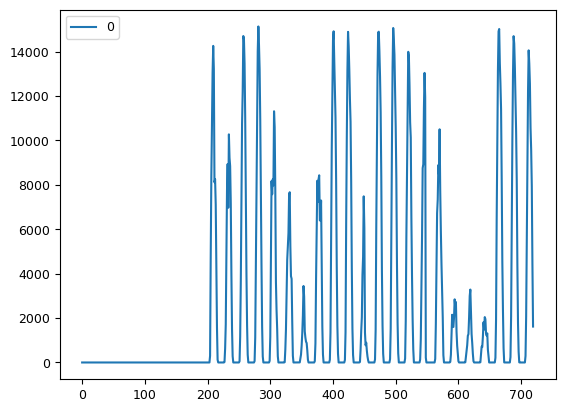

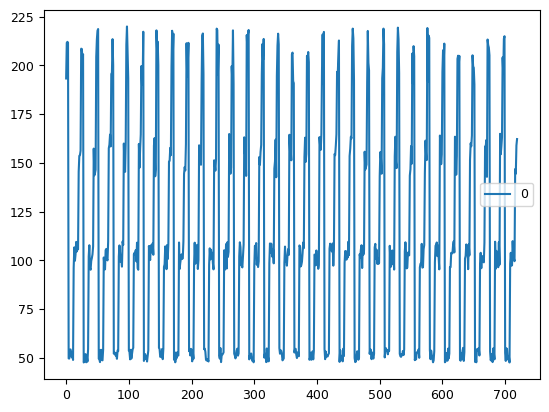

In [19]:
# print(data_np_segments[1])
pd.DataFrame(data_np[:,3]).plot()
pd.DataFrame(data_np[:,4]).plot()
plt.show()

# __<u>Comparative Analysis of Genetic Algorithm and Innovative Stochastic Algorithm for Photovoltaic Charge/Discharge Control in Grid Systems</u>__

> <u>Load the provided dataset</u>

In [20]:
data = data_np
data

array([[   0. ,    0. ,    0. ,    0. ,  193.3],
       [   0. ,    0. ,    0. ,    0. ,  211.6],
       [   0. ,    0. ,    0. ,    0. ,  212.1],
       ...,
       [2101.6, 2716.1, 3125.3, 7943. ,  144.4],
       [1229.9, 1350.9, 1852.1, 4432.9,  158.9],
       [ 451. ,  488.7,  678.1, 1617.8,  162.2]])

In [21]:
def forecast(data, order=(1, 0, 0)):
    model = ARIMA(data, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=1)
    return forecast[0]

def generic_algorithm(data, ess_capacity):
    n_pv = 3
    ess = np.zeros(n_pv)
    charge = np.zeros_like(data)
    discharge = np.zeros_like(data)
    
    for i in range(len(data)):
        for j in range(n_pv):
            pv_power = data[i, j]
            grid_demand = data[i, -1]
            
            if pv_power > grid_demand:
                charge_amount = min(ess_capacity - ess[j], pv_power - grid_demand)
                ess[j] += charge_amount
                charge[i, j] = charge_amount
            else:
                discharge_amount = min(ess[j], grid_demand - pv_power)
                ess[j] -= discharge_amount
                discharge[i, j] = discharge_amount
                
    return charge, discharge

def stochastic_algorithm(data, ess_capacity):
    n_pv = 3
    ess = np.zeros(n_pv)
    charge = np.zeros_like(data)
    discharge = np.zeros_like(data)
    
    for i in range(len(data) - 1):
        for j in range(n_pv):
            pv_power = data[i, j]
            grid_demand = data[i, -1]
            
            pv_forecast = forecast(data[:, j])
            grid_demand_forecast = forecast(data[:, -1])
            
            if pv_forecast > grid_demand_forecast:
                charge_amount = min(ess_capacity - ess[j], pv_power - grid_demand)
                ess[j] += charge_amount
                charge[i, j] = charge_amount
            else:
                discharge_amount = min(ess[j], grid_demand - pv_power)
                ess[j] -= discharge_amount
                discharge[i, j] = discharge_amount
                
    return charge, discharge

def visualize_charging_discharging(data, charge, discharge, title):
    n_pv = 3
    time = np.arange(len(data))
    labels = ['PV1', 'PV2', 'PV3']
    
    fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    
    for j in range(n_pv):
        ax[0].plot(time, charge[:, j], label=labels[j])
    ax[0].set_title(f'ESS Charging - {title}')
    ax[0].set_ylabel('Charging (kWh)')
    ax[0].legend()
    
    for j in range(n_pv):
        ax[1].plot(time, discharge[:, j], label=labels[j])
    ax[1].set_title(f'ESS Discharging - {title}')
    ax[1].set_xlabel('Time (hours)')
    ax[1].set_ylabel('Discharging (kWh)')
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()

def compare_algorithms(data, ess_capacity):
    charge_gen, discharge_gen = generic_algorithm(data, ess_capacity)
    charge_stoch, discharge_stoch = stochastic_algorithm(data, ess_capacity)
    
    total_discharge_gen = np.sum(discharge_gen, axis=0)
    total_discharge_stoch = np.sum(discharge_stoch, axis=0)
    
    ind = np.arange(3)
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(ind - width/2, total_discharge_gen, width, label='Generic Algorithm')
    rects2 = ax.bar(ind + width/2, total_discharge_stoch, width, label='Stochastic Algorithm')

    ax.set_title('Comparison of Discharging Energy between Algorithms')
    ax.set_xticks(ind)
    ax.set_xticklabels(['PV1', 'PV2', 'PV3'])
    ax.set_ylabel('Total Discharging Energy (kWh)')
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.tight_layout()
    plt.show()


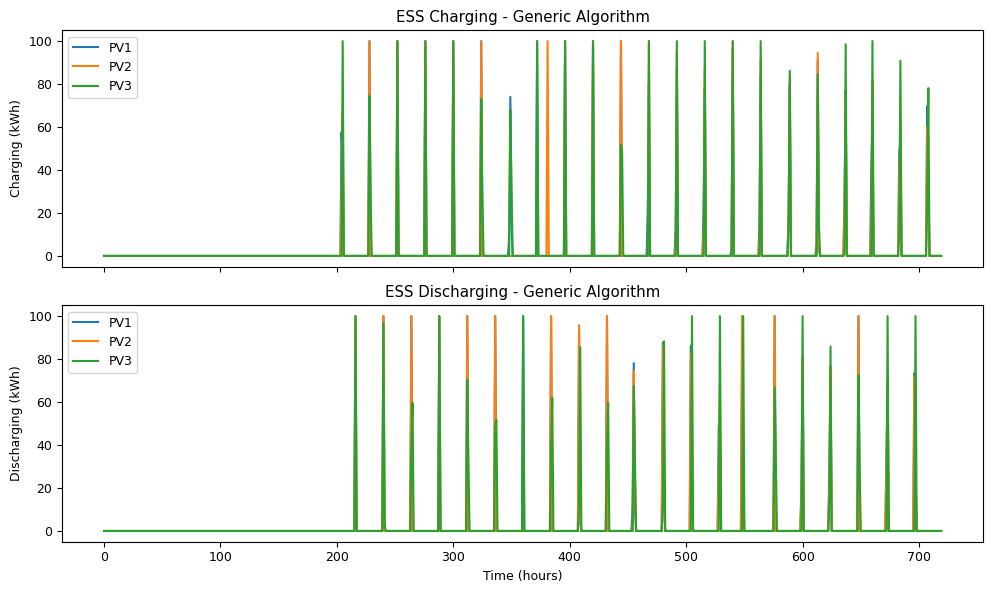

In [22]:
# ESS capacity
ess_capacity = 100

# Algorithm 1: Generic Algorithm
charge_gen, discharge_gen = generic_algorithm(data, ess_capacity)
visualize_charging_discharging(data, charge_gen, discharge_gen, 'Generic Algorithm')

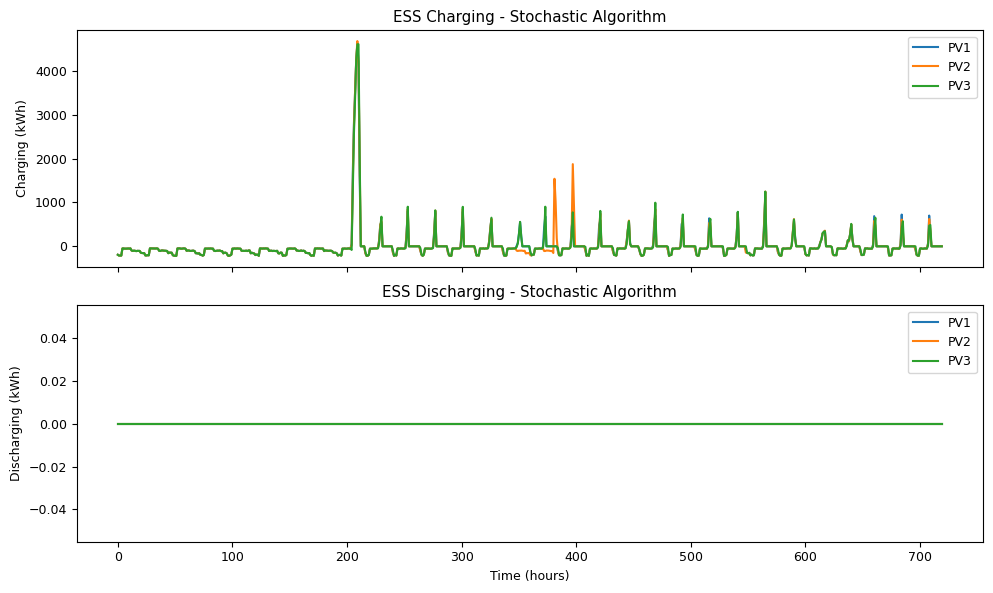

In [23]:
# Algorithm 2: Stochastic Algorithm
charge_stoch, discharge_stoch = stochastic_algorithm(data, ess_capacity)
visualize_charging_discharging(data, charge_stoch, discharge_stoch, 'Stochastic Algorithm')

In [24]:
# Comparison
# compare_algorithms(data, ess_capacity)

> <u>Cost function (RMSE)</u>

In [25]:
def cost_function(individual, data):
    total_pv = data[:, 3]
    grid_demand = data[:, 4]
    ess_capacity = 100  # Assume an ESS capacity of 100 kWh
    ess_charge = np.zeros_like(grid_demand)
    current_charge = 0
    
    for i, action in enumerate(individual):
        if action >= 0:
            charge_amount = min(ess_capacity - current_charge, action)
            current_charge += charge_amount
            print(f"Step {i+1}: Charging ESS with {charge_amount} kWh")
        else:
            discharge_amount = max(-current_charge, action)
            current_charge += discharge_amount
            print(f"Step {i+1}: Discharging ESS with {-discharge_amount} kWh")

        ess_charge[i] = current_charge

    predicted_demand = grid_demand - (total_pv + ess_charge)
    rmse = np.sqrt(np.mean((predicted_demand - grid_demand)**2))
    return rmse, ess_charge

> <u>Genetic Algorithm (GA)</u>

In [26]:
def ga_optimization(data, population_size, generations):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("attr_float", random.uniform, -1, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, len(data))
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.1)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", cost_function, data=data)

    pop = toolbox.population(n=population_size)
    hof = tools.HallOfFame(1)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=generations, stats=stats, halloffame=hof, verbose=True)

    return hof[0], logbook, hof[0].fitness.values[1]

> <u>Innovative Stochastic Algorithm</u>
>> Enhanced Adaptive Heuristic Search Algorithm (EAHSA)

In [27]:
def stochastic_algorithm(data, population_size, iterations):
    def create_individual():
        return [random.uniform(-1, 1) for _ in range(len(data))]

    def mutate(individual):
        for i in range(len(individual)):
            if random.random() < 0.1:
                individual[i] += random.gauss(0, 0.2)
                # individual[i] = max(min(individual[i], 1), -1)

    population = [create_individual() for _ in range(population_size)]
    best_individual = None
    best_fitness = float("inf")
    fitness_values = []

    for _ in range(iterations):
        for individual in population:
            fitness = cost_function(individual, data)
            if fitness[0] < best_fitness:
                best_fitness = fitness[0]
                best_individual = individual

        # Mutation
        for individual in population:
            mutate(individual)

        fitness_values.append(best_fitness)

    return best_individual, fitness_values, best_individual_fitness.values[1]

> <u>Main function</u>

In [28]:
def main():
    population_size = 50
    generations = 100
    iterations = 100

    # Genetic Algorithm optimization
    ga_best_individual, ga_logbook = ga_optimization(data, population_size, generations)
    ga_best_fitness_values = [log["min"] for log in ga_logbook]

    # Stochastic Algorithm optimization
    sa_best_individual, sa_best_fitness_values = stochastic_algorithm(data, population_size, iterations)

    # Plot the results
    fig, ax = plt.subplots(figsize=(18, 6))
    fig.set_facecolor(color='antiquewhite')
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams['font.size'] = '9'

    ax.plot(ga_best_fitness_values, label="Genetic Algorithm", color='gray')
    ax.plot(sa_best_fitness_values, label="Enhanced Adaptive Heuristic Search Algorithm (EAHSA)", color='blue')

    ax.set_xlabel("Iteration", color='chocolate')
    ax.set_ylabel("Best Fitness Value", color='chocolate')
    ax.set_title("Comparison of GA and EAHSA for Optimization", color='brown')
    ax.legend(loc="upper right")
    ax.grid(True, linestyle='--', alpha=0.7, color='salmon')

    plt.show()

> <u>Run Main Program</u>

In [29]:
if __name__ == "__main__":
    main()

Step 1: Charging ESS with 0.6405740118572718 kWh
Step 2: Discharging ESS with 0.6405740118572718 kWh
Step 3: Charging ESS with 0.14540238092060376 kWh
Step 4: Charging ESS with 0.5082871227035886 kWh
Step 5: Charging ESS with 0.05219715819560067 kWh
Step 6: Charging ESS with 0.8023916540059621 kWh
Step 7: Charging ESS with 0.818766895472973 kWh
Step 8: Charging ESS with 0.06362810773780692 kWh
Step 9: Charging ESS with 0.26896849881956886 kWh
Step 10: Charging ESS with 0.6038091946464144 kWh
Step 11: Charging ESS with 0.02314182627163408 kWh
Step 12: Charging ESS with 0.3913864618545613 kWh
Step 13: Discharging ESS with 0.13990838549283113 kWh
Step 14: Charging ESS with 0.15064433734798044 kWh
Step 15: Discharging ESS with 0.11247663873812463 kWh
Step 16: Discharging ESS with 0.0322239160500275 kWh
Step 17: Discharging ESS with 0.05066991453388714 kWh
Step 18: Discharging ESS with 0.9182536378863728 kWh
Step 19: Charging ESS with 0.37569536339028775 kWh
Step 20: Discharging ESS with 0.

AssertionError: Assigned values have not the same length than fitness weights